## import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix
# random state
rs = 42

## Split Data

In [2]:
# Load the data
train = pd.read_csv('../data/Train_data.csv')
test = pd.read_csv('../data/test_data.csv')

# Combine train and test data
combined_data = pd.concat([train, test], ignore_index=True)

# Define the target variable
target_column = 'Disease'

# Split combined data into X (features) and y (target)
X = combined_data.drop(columns=[target_column])
y = combined_data[target_column]

# Split the combined data into new train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y)

# If you need to check the shapes of the resulting dataframes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2269, 24)
y_train shape: (2269,)
X_test shape: (568, 24)
y_test shape: (568,)


## Resampling 

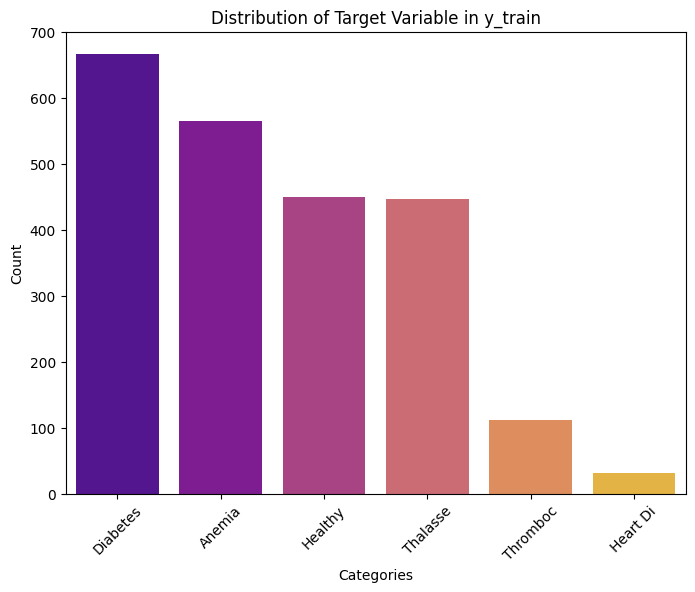

In [3]:
y_train_counts = y_train.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=y_train_counts.index, y=y_train_counts,hue = y_train_counts.index, palette="plasma")
plt.title('Distribution of Target Variable in y_train')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

imbalanced classes in a multiclass classification problem, resampling techniques can help to balance the class distributions.

In [5]:
# Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_res , y_train_res  = smote.fit_resample(X_train, y_train)

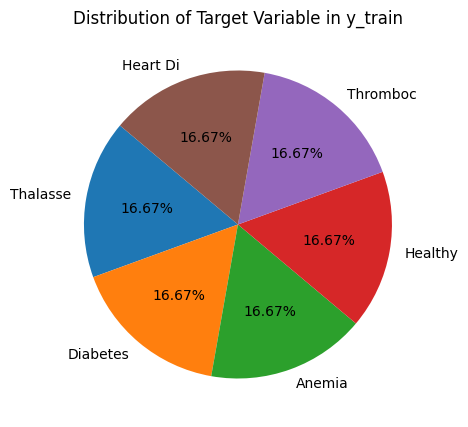

X_train shape: (4002, 24)
y_train shape: (4002,)


In [6]:
# Generate a pie chart for y_train
y_train_counts = y_train_res.value_counts()
plt.figure(figsize=(5, 5))
plt.pie(y_train_counts, labels=y_train_counts.index, autopct='%.2f%%', startangle=140)
plt.title('Distribution of Target Variable in y_train')
plt.show()
print(f"X_train shape: {X_train_res.shape}")
print(f"y_train shape: {y_train_res.shape}")

## Random Forset Model

In [7]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=rs)
rf.fit(X_train_res, y_train_res)
rf_preds = rf.predict(X_test)

# Calculate the metrics
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds, average='weighted')
rf_recall = recall_score(y_test, rf_preds, average='weighted')
rf_f1 = f1_score(y_test, rf_preds, average='weighted')
# Classification Report
rf_classification_report = classification_report(y_test, rf_preds)
# Print metrics for Random Forest model with formatting
print("Random Forest Model Metrics:")
print("Accuracy: {:.2f} %\nPrecision: {:.2f} %\nRecall: {:.2f} %\nF1 Score: {:.2f} %".format(
    rf_accuracy * 100, rf_precision * 100, rf_recall * 100, rf_f1 * 100))
print("\nClassification Report for Random Forest Model:\n", rf_classification_report)

Random Forest Model Metrics:
Accuracy: 96.13 %
Precision: 96.22 %
Recall: 96.13 %
F1 Score: 96.08 %

Classification Report for Random Forest Model:
               precision    recall  f1-score   support

      Anemia       1.00      0.96      0.98       142
    Diabetes       0.90      0.98      0.94       167
     Healthy       1.00      0.98      0.99       112
    Heart Di       0.50      0.38      0.43         8
    Thalasse       1.00      0.95      0.97       111
    Thromboc       0.97      1.00      0.98        28

    accuracy                           0.96       568
   macro avg       0.89      0.87      0.88       568
weighted avg       0.96      0.96      0.96       568



- **Overall Performance:** The Random Forest model achieves high accuracy, precision, recall, and F1-score, indicating strong performance on the test data.

- **Accuracy:** The accuracy of 96.13% suggests that the model correctly classifies the majority of the instances in the test set.

- **Precision and Recall:** Precision measures the accuracy of positive predictions, while recall measures the proportion of actual positives that were correctly identified by the model.
    - Precision
        - The precision values vary across classes, ranging from 50% to 100%.
        - Precision for classes like "Anemia," "Diabetes," "Healthy," "Thalassemia," and "Thrombocytopenia" is very high (above 89%), indicating a low false-positive rate.
        - However, the precision for the "Heart Disease" class is lower at 50%, suggesting that there is a high rate of false positives for this class.
    - Recall
        - Recall values also vary across classes, ranging from 38% to 100%.
        - The recall for the "Heart Disease" class is relatively low at 38%, indicating that the model misses a significant proportion of actual instances of "Heart Disease."

- **F1 Score:** The F1-score, which is the harmonic mean of precision and recall, provides a balance between the two metrics. The weighted average F1-score of 96.08% indicates excellent overall model performance.

- **Class Imbalance:** The classification report shows variations in precision, recall, and F1-score across different classes, suggesting class imbalance may be present in the dataset. This imbalance could affect the model's performance, particularly for minority classes like "Heart Disease."

It's not uncommon for resampling techniques to not fully address class imbalance, especially if the class distribution is highly skewed or if the minority class has very few instances. 

#### Model Tuning: 
While the model already performs well, there may still be room for improvement through further parameter tuning. 

Specifically addressing the class imbalance issue, perhaps try another techniques like adjusting class weights, could potentially improve the model's performance, especially for classes with lower precision and recall.

In [8]:
# Define the parameter grid
param_grid = {
    'n_estimators': list(range(1, 106, 5)),
    'max_depth': list(range(1, 31)),
    'random_state': [rs]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best n_estimators: {best_params['n_estimators']}")
print(f"Best max_depth: {best_params['max_depth']}")
print(f"Best model: {best_model}")

Best n_estimators: 41
Best max_depth: 13
Best model: RandomForestClassifier(max_depth=13, n_estimators=41, random_state=42)


In [9]:
# Define a range of weights to try for each class
weights_per_class_to_try = [1,2,3]

# Initialize variables to store the best weights and its corresponding performance
best_weights = None
best_score = 0

# Iterate over each combination of weights for each class
for weights_combination in itertools.product(weights_per_class_to_try, repeat=len(np.unique(y_train_res))):
    # Create a dictionary to map each class to its respective weight
    class_weight = {class_name: weight for class_name, weight in zip(np.unique(y_train_res), weights_combination)}
    
    # Define the Random Forest classifier with the current class weights
    rf = RandomForestClassifier(**best_params, class_weight=class_weight)
    
    # Perform cross-validation
    scores = cross_val_score(rf, X_train_res, y_train_res, cv=5, scoring='accuracy',n_jobs=-1)
    
    # Calculate the mean accuracy score
    mean_score = scores.mean()
    
    # Check if the current weights give better performance
    if mean_score > best_score:
        best_score = mean_score
        best_weights = class_weight

# After the loop, you'll have the best class weights for each class
print("Best Class Weights:", best_weights)
print("Best Cross-Validation Accuracy:", best_score)

Best Class Weights: {'Anemia': 2, 'Diabetes': 3, 'Healthy': 1, 'Heart Di': 2, 'Thalasse': 1, 'Thromboc': 1}
Best Cross-Validation Accuracy: 0.9855081148564295


In [15]:
# Random Forest Classifier
rf = RandomForestClassifier(**best_params , class_weight=best_weights)
rf.fit(X_train_res, y_train_res)
rf_preds = rf.predict(X_test)

# Calculate the metrics
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds, average='weighted')
rf_recall = recall_score(y_test, rf_preds, average='weighted')
rf_f1 = f1_score(y_test, rf_preds, average='weighted')
# Classification Report
rf_classification_report = classification_report(y_test, rf_preds)
# Print metrics for Random Forest model with formatting
print("Random Forest Model Metrics:")
print("Accuracy: {:.2f} %\nPrecision: {:.2f} %\nRecall: {:.2f} %\nF1 Score: {:.2f} %".format(
    rf_accuracy * 100, rf_precision * 100, rf_recall * 100, rf_f1 * 100))
print("\nClassification Report for Random Forest Model:\n", rf_classification_report)

Random Forest Model Metrics:
Accuracy: 97.18 %
Precision: 97.28 %
Recall: 97.18 %
F1 Score: 97.18 %

Classification Report for Random Forest Model:
               precision    recall  f1-score   support

      Anemia       0.99      0.97      0.98       142
    Diabetes       0.94      0.99      0.96       167
     Healthy       1.00      1.00      1.00       112
    Heart Di       0.75      0.75      0.75         8
    Thalasse       1.00      0.93      0.96       111
    Thromboc       0.97      1.00      0.98        28

    accuracy                           0.97       568
   macro avg       0.94      0.94      0.94       568
weighted avg       0.97      0.97      0.97       568



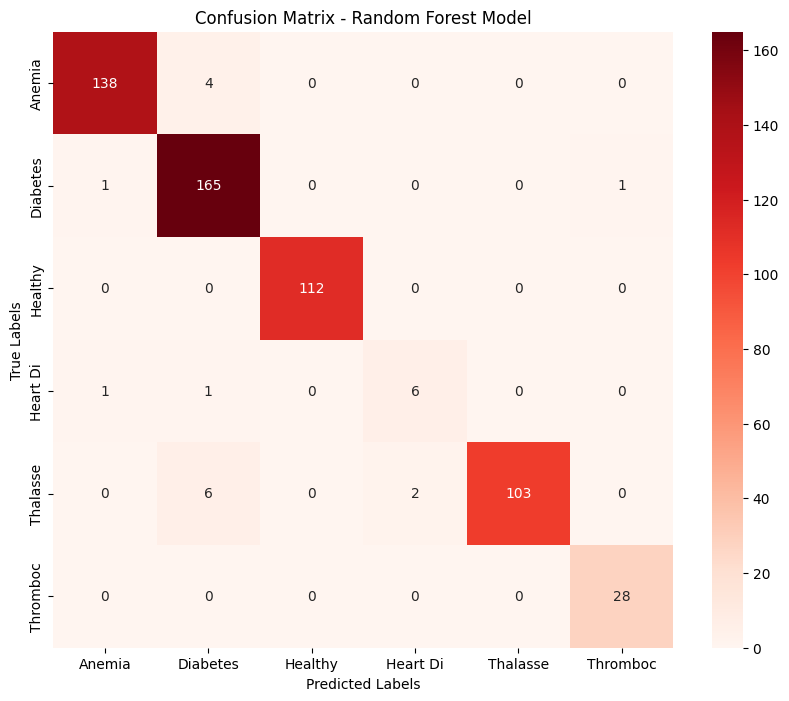

In [19]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Reds", fmt="d", xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix - Random Forest Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The improvements observed in the model's performance metrics after tuning and incorporating class weights are quite promising. 

1. **Increased Accuracy**: The accuracy has risen from 96.13% to 97.18%, indicating that the model is now better at making correct predictions across all classes.

2. **Enhanced Precision and Recall**: Precision and recall measures have seen significant improvements across various classes. This indicates that the model is not only making fewer mistakes but also correctly identifying more instances of each class.

3. **Balanced F1-Score**: The F1-score, which is a harmonic mean of precision and recall, has also increased. This suggests that the model is achieving a better balance between precision and recall for each class, resulting in improved overall performance.

4. **Class-Specific Improvements**: Looking at the classification report, we can see improvements in precision, recall, and F1-score for specific classes. This means that the model is now more effective at correctly classifying instances of each class, leading to more reliable predictions.

5. **Generalization Improvement**: By reducing overfitting and improving generalization performance, the model is now better equipped to handle unseen data, which is crucial for real-world applications.

Overall, these enhancements indicate that the model tuning and incorporation of class weights have been successful in improving the model's accuracy, precision, recall, and overall performance, making it more robust and reliable for classification tasks.

## Check Overfitting

In [10]:
# Convert pandas DataFrames to numpy arrays
X_train = X_train_res.values
y_train = y_train_res.values

# Define the number of folds for k-fold cross-validation
k = 10

# Initialize the KFold object
kf = KFold(n_splits=k, shuffle=True)

# Initialize a list to store the accuracies for each fold
accuracies = []

# Iterate over each fold
for train_index, test_index in kf.split(X_train):
    # Split data into training and testing sets for this fold
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Initialize and train a Random Forest Classifier
    rf_classifier = RandomForestClassifier(**best_params , class_weight=best_weights)
    rf_classifier.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test_fold)
    
    # Calculate accuracy for this fold and store it
    accuracy = accuracy_score(y_test_fold, y_pred)
    accuracies.append(accuracy)

# Calculate the mean and standard deviation of accuracies
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print("Mean Accuracy: {:.2f} %".format(mean_accuracy * 100))
print("Standard Deviation of Accuracy:{:.5f}".format(std_accuracy))

Mean Accuracy: 98.53 %
Standard Deviation of Accuracy:0.00627


## Random Forest Model Performance Report

### Test Set Metrics:
- **Accuracy:** 97.18%
- **Precision:** 97.28%
- **Recall:** 97.18%
- **F1 Score:** 97.18%

### Classification Report:
| Class     | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| Anemia    | 0.99      | 0.97   | 0.98     | 142     |
| Diabetes  | 0.94      | 0.99   | 0.96     | 167     |
| Healthy   | 1.00      | 1.00   | 1.00     | 112     |
| Heart Di  | 0.75      | 0.75   | 0.75     | 8       |
| Thalasse  | 1.00      | 0.93   | 0.96     | 111     |
| Thromboc  | 0.97      | 1.00   | 0.98     | 28      |

### Overall Metrics:
- **Accuracy (Test Set):** 97.18%
- **Mean Accuracy (k-fold CV):** 98.50%
- **Standard Deviation of Accuracy:** 0.00612

### Conclusion:
The Random Forest model demonstrates robust performance across various metrics. It achieves high accuracy, precision, recall, and F1-score on the test set, indicating its effectiveness in making accurate predictions. The model exhibits consistency in performance across different subsets of the training data, as evidenced by the high mean accuracy and low standard deviation in k-fold cross-validation. Overall, the Random Forest model is well-suited for the classification task at hand.